# NOTES

1. macd histogram (exponential moving averages ... n-day)
1. adx/dmi
1. parabalic sar 

In [4]:
import pytz
from datetime import datetime
from zipline.algorithm import TradingAlgorithm
from zipline.utils.factory import load_from_yahoo, load_bars_from_yahoo
from zipline.finance import trading, slippage
from zipline.finance.commission import PerShare
import talib

In [7]:
import Quandl, os, datetime, pandas, matplotlib
auth = 'GMs5ZwtAzsTP6MAHoyCH' # please do not abuse
save_dir = 'energy/quandl'
hist_pattern = "OFDP/FUTURE_CL%s%s" # ex FUTURE_NGJ1991 
roll_pattern = "OFDP/FUTURE_CL%s" # ex FUTURE_NG1 
month_map = 'F	G	H	J	K	M	N	Q	U	V	X	Z'.split()
trim_start = '2000-01-01'
trim_end = datetime.datetime.today().strftime('%Y-%m-%d')

def getFilename(dataset):
    return(os.path.join(save_dir, dataset + '.csv.gz'))

In [8]:
# the historical (single contract) time series
dfs = []
start_year = 2000
end_year = 2025
for i in range(len(month_map)):
    for j in range(end_year - start_year + 1):
        year = str(start_year + j)
        month = month_map[i]
        maturity = datetime.datetime(int(year), i+1, 1)
        dataset = hist_pattern % (month, year)
        f = getFilename(dataset)
        if not os.path.exists(f):
            print('Pulling data for %s' % f)
            if not os.path.exists(os.path.dirname(f)):
                os.makedirs(os.path.dirname(f))
            try:
                temp = Quandl.get(dataset, authtoken=auth, trim_start=trim_start, trim_end=trim_end, 
                              sort_order='desc')
            except Exception as e:
                print('Problem getting %s: %s' % (dataset, e))
                
            print(temp.shape)
            savefile = f.replace('.gz', '')
            temp.to_csv(savefile)
            cmd = 'gzip -f %s' % savefile
            print(cmd)
            os.system(cmd)
        else:
            pass
            # print('%s exists. Not repulling' % f)
            try:
                temp = pandas.read_csv(f, header=0, parse_dates=['Date'], compression='gzip')
            except Exception as e:
                print("Could not read %s ... skipping " % f)
                continue
        temp['Maturity'] = maturity
        dfs += [temp]
dfs = pandas.concat(dfs, axis=0)
dfs = dfs.set_index(['Maturity', 'Date'])
hdf = dfs.copy()
hdf = hdf.sort_index()
hdf = hdf.sort_index(axis=1)
dfs = None
print(hdf.shape)

Could not read energy/quandl/OFDP/FUTURE_CLF2000.csv.gz ... skipping 
(180480, 7)


In [9]:
hdf = hdf.dropna(how='all', axis=0)
hdf.head(n=20)

High    Low   Open  Open Interest  Settle  Unnamed: 0  \
Maturity   Date                                                                 
2000-02-01 2000-01-04  25.69  24.75  25.05         124650   25.55         NaN   
           2000-01-05  25.40  24.87  25.15         123257   24.91         NaN   
           2000-01-06  25.34  24.51  24.70         120443   24.78         NaN   
           2000-01-07  25.02  24.15  24.80         116577   24.22         NaN   
           2000-01-10  24.75  24.02  24.35         114426   24.67         NaN   
           2000-01-11  25.80  24.91  24.95          88479   25.77         NaN   
           2000-01-12  26.55  25.41  25.48          80240   26.28         NaN   
           2000-01-13  27.12  26.42  26.50          83885   26.69         NaN   
           2000-01-14  28.10  27.00  27.10          93646   28.02         NaN   
           2000-01-18  29.00  27.96  28.48          57045   28.85         NaN   
           2000-01-19  29.68  28.55  28.55          34744   29.54         NaN   
           2000-01-20  29.95  28.68  29.45          10833   29.66         NaN   
2000-03-01 2000-01-04  25.00  24.12  24.25          69865   24.84         NaN   
           2000-01-05  24.73  24.23  24.50          71701   24.27         NaN   
           2000-01-06  24.70  23.90  24.05          75560   24.20         NaN   
           2000-01-07  24.46  23.70  24.21          81817   23.76         NaN   
           2000-01-10  24.20  23.57  23.90          86512   24.13         NaN   
           2000-01-11  25.15  24.40  24.40          88333   25.11         NaN   
           2000-01-12  25.91  24.80  24.85          95678   25.66         NaN   
           2000-01-13  26.25  25.80  25.85         108551   25.92         NaN   

                       Volume  
Maturity   Date                
2000-02-01 2000-01-04   74788  
           2000-01-05   70944  
           2000-01-06   85252  
           2000-01-07   91828  
           2000-01-10   68901  
           2000-01-11  106490  
           2000-01-12   93757  
           2000-01-13   90217  
           2000-01-14   68806  
           2000-01-18   65196  
           2000-01-19   69987  
           2000-01-20   57715  
2000-03-01 2000-01-04   26901  
           2000-01-05   30967  
           2000-01-06   44495  
           2000-01-07   50388  
           2000-01-10   37781  
           2000-01-11   57297  
           2000-01-12   69356  
           2000-01-13   75425  

[20 rows x 7 columns]

In [10]:
# cut down the dates if you want
start = '2012-01-01'
hdf = hdf.unstack('Maturity').ix[start:].stack('Maturity')
hdf.index = hdf.index.reorder_levels([1, 0])
print(hdf.shape)
hdf.head()

(42814, 7)


,,High,Low,Open,Open Interest,Settle,Unnamed: 0,Volume
Maturity,Date,,,,,,,
2012-02-01,2012-01-03,103.18,99.65,99.70,227132,102.96,NaN,275481
2012-03-01,2012-01-03,103.36,99.75,99.75,173841,103.14,NaN,115070
2012-04-01,2012-01-03,103.50,100.30,100.30,86356,103.32,NaN,56530
2012-05-01,2012-01-03,103.57,100.30,100.30,80605,103.42,NaN,37101
2012-06-01,2012-01-03,103.52,100.70,100.70,98897,103.35,NaN,64993


In [11]:
S = hdf[['Settle']].sort_index()
S.columns = ['s']
S = S.reset_index()
S['Term'] = S.Maturity - S.Date
def toDays(x):
    x = x.astype('timedelta64[D]')
    return(x / np.timedelta64(1, 'D'))
S['Term'] = S['Term'].apply(toDays)
S['Month'] = S['Maturity'].apply(lambda x: x.month)
S.head()

,Maturity,Date,s,Term,Month
0,2012-02-01,2012-01-03,102.96,29,2
1,2012-02-01,2012-01-04,103.22,28,2
2,2012-02-01,2012-01-05,101.81,27,2
3,2012-02-01,2012-01-06,101.56,26,2
4,2012-02-01,2012-01-09,101.31,23,2


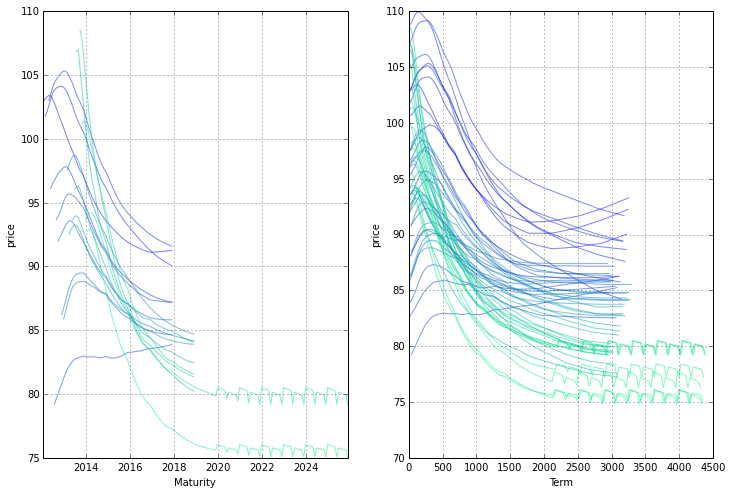

In [13]:
m = S.set_index('Date')

mats = m.Maturity.unique()
mats.sort()
dates = m.index.unique()
colors = np.linspace(0.1, 1, len(dates))
mymap = plt.get_cmap("winter")

figure(figsize=(12, 8))
subplot(121)
for i, k in enumerate(dates):
    if (i % 30) == 0:
        temp = m.ix[k].set_index('Maturity')['s']
        temp = temp.reindex_axis(mats)
        plot(temp.index, temp.values, alpha=0.5, color=mymap(float(i) / len(dates)))
grid()
t = ylabel('price')
t = xlabel('Maturity')

subplot(122)
for i, k in enumerate(dates):
    if (i % 10) == 0:
        temp = m.ix[k].set_index('Term')['s']
        # temp = temp.reindex_axis(terms)
        # temp = log(temp)
        plot(temp.index, temp.values, alpha=0.5, color=mymap(float(i) / len(dates)))
grid()
t = ylabel('price')
t = xlabel('Term')

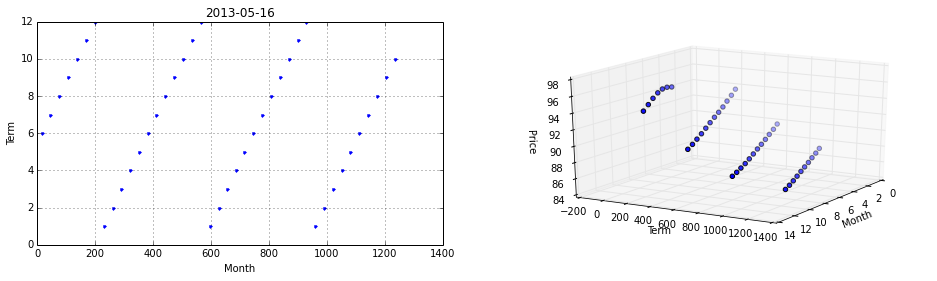

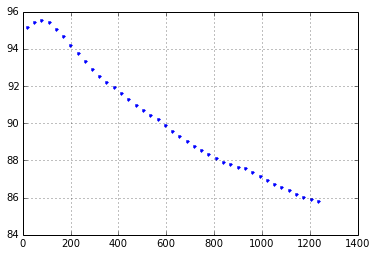

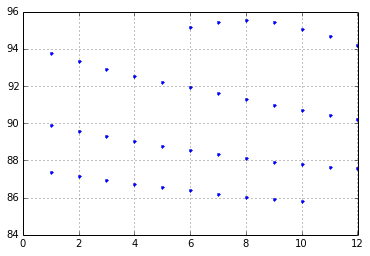

In [49]:
date = S['Date'].ix[randint(S.shape[0])]

data = S[S['Date'] == date]
data = data.sort(['Term', 'Month'])

data.index = arange(data.shape[0])
data = data.ix[:40]

# this is the data you will fit
x, y, z = [data[k].values for k in ['Month', 'Term', 's']]
y = array(y, dtype=int) # I am relying on y being int to use directly as an index! Could change with a dict mapping if needed
figure(figsize=(16, 4))
ax = subplot(121)
plot(y, x, '.'); grid()
xlabel('Month')
ylabel('Term')
title('%s' % date.strftime('%Y-%m-%d'))

from mpl_toolkits.mplot3d import Axes3D
ax = subplot(122, projection='3d')
l = ax.scatter(x, y, z)
ax.set_xlabel('Month')
ax.set_ylabel('Term')
l = ax.set_zlabel('Price')
ax.view_init(20, 30)

figure()
plot(y, z, '.')
grid()

figure()
plot(x, z, '.')
grid()

# OK, let's just deal with rolling?

In [16]:
dfs = []
for i in range(1, 48):
    dataset = roll_pattern % str(i + 1)
    f = getFilename(dataset)
    if not os.path.exists(f):
        print('Pulling data for %s' % f)
        if not os.path.exists(os.path.dirname(f)):
            os.makedirs(os.path.dirname(f))
        try:
            temp = Quandl.get(dataset, authtoken=auth, trim_start=trim_start, trim_end=trim_end, 
                          sort_order='desc')
        except Exception as e:
            print('Problem getting %s: %s' % (dataset, e))
            
        print(temp.shape)
        savefile = f.replace('.gz', '')
        temp.to_csv(savefile)
        cmd = 'gzip -f %s' % savefile
        print(cmd)
        os.system(cmd)
    else:
        pass
        # print('%s exists. Not repulling' % f)
        try:
            temp = pandas.read_csv(f, header=0, parse_dates=['Date'], compression='gzip')
        except Exception as e:
            print("Could not read %s ... skipping " % f)
            continue
    temp['Maturity'] = maturity
    dfs += [temp]
dfs = pandas.concat(dfs, axis=0)
dfs = dfs.set_index(['Maturity', 'Date'])
hdf = dfs.copy()
hdf = hdf.sort_index()
hdf = hdf.sort_index(axis=1)
dfs = None
print(hdf.shape)

Pulling data for energy/quandl/OFDP/FUTURE_CL2.csv.gz
Token GMs5ZwtAzsTP6MAHoyCH activated and saved for later use.
Returning Dataframe for  OFDP/FUTURE_CL2
(3544, 6)
gzip -f energy/quandl/OFDP/FUTURE_CL2.csv
Pulling data for energy/quandl/OFDP/FUTURE_CL3.csv.gz
Token GMs5ZwtAzsTP6MAHoyCH activated and saved for later use.
Returning Dataframe for  OFDP/FUTURE_CL3
(3543, 6)
gzip -f energy/quandl/OFDP/FUTURE_CL3.csv
Pulling data for energy/quandl/OFDP/FUTURE_CL4.csv.gz
Token GMs5ZwtAzsTP6MAHoyCH activated and saved for later use.
Returning Dataframe for  OFDP/FUTURE_CL4
(3541, 6)
gzip -f energy/quandl/OFDP/FUTURE_CL4.csv
Pulling data for energy/quandl/OFDP/FUTURE_CL5.csv.gz
Token GMs5ZwtAzsTP6MAHoyCH activated and saved for later use.
Returning Dataframe for  OFDP/FUTURE_CL5
(3540, 6)
gzip -f energy/quandl/OFDP/FUTURE_CL5.csv
Pulling data for energy/quandl/OFDP/FUTURE_CL6.csv.gz
Token GMs5ZwtAzsTP6MAHoyCH activated and saved for later use.
Returning Dataframe for  OFDP/FUTURE_CL6
(3542, 

KeyError: 'no item named Date'

 OFDP/FUTURE_CL48
(1651, 6)
gzip -f energy/quandl/OFDP/FUTURE_CL48.csv
